# Example 1: Mean Risk Optimisation

## 1. Download data.

In [1]:
using PortfolioOptimiser, TimeSeries, DataFrames, PrettyTables, Clarabel, HiGHS, YFinance,
      GraphRecipes, StatsPlots, JuMP

# Format for pretty tables.
fmt1 = (v, i, j) -> begin
    if j == 1
        return Date(v)
    else
        return v
    end
end;
fmt2 = (v, i, j) -> begin
    if j == 1
        return v
    else
        return isa(v, Number) ? "$(round(v*100, digits=3)) %" : v
    end
end;

# Convert prices to time array.
function stock_price_to_time_array(x)
    # Only get the keys that are not ticker or datetime.
    coln = collect(keys(x))[3:end]
    # Convert the dictionary into a matrix.
    m = hcat([x[k] for k ∈ coln]...)
    return TimeArray(x["timestamp"], m, Symbol.(coln), x["ticker"])
end

# Asset tickers.
assets = sort!(["AAPL", "ADI", "ADP", "AMGN", "AMZN", "BKNG", "CMCSA", "COST", "CSCO",
                "GILD", "GOOG", "GOOGL", "HON", "ISRG", "LIN", "MAR", "META", "MRK", "MSFT",
                "NFLX", "NVDA", "ORLY", "PANW", "QCOM", "SBUX", "T", "TMUS", "TSLA", "TXN",
                "VRTX"])

# Prices date range.
Date_0 = "2019-01-01"
Date_1 = "2025-01-31"

# Download the price data using YFinance.
prices = get_prices.(assets; startdt = Date_0, enddt = Date_1)
prices = stock_price_to_time_array.(prices)
prices = hcat(prices...)
cidx = colnames(prices)[occursin.(r"adj", string.(colnames(prices)))]
prices = prices[cidx]
TimeSeries.rename!(prices, Symbol.(assets))
pretty_table(prices[1:5]; formatters = fmt1)

┌────────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┬─────────┐
│  timestamp │    AAPL │     ADI │     ADP │    AMGN │    AMZN │    BKNG │   CMCSA │    COST │    CSCO │    GILD │    GOOG │   GOOGL │     HON │    ISRG │     LIN │     MAR │    META │     MRK │    MSFT │    NFLX │    NVDA │    ORLY │    PANW │    QCOM │    SBUX │       T │    TMUS │    TSLA │     TXN │    VRTX │
│   DateTime │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │ Float64 │
├────────────┼─────────┼─────────┼─────────┼─────────┼─

## 2. Estimating Mean Risk Portfolios

### 2.1. Optimising portfolio

This is a simple example so we will only use default parameters for computing the statistics.

For API details and options available see: `Portfolio`, `PortOptSolver`, `PortfolioOptimiser.MeanEstimator`, `PortfolioOptimiser.PortfolioOptimiserCovCor`, `asset_statistics!`, `RiskMeasure`, `PortfolioOptimiser.ObjectiveFunction`, `PortfolioOptimiser.OptimType`.

In [2]:
# Creating the portfolio object. Internally computes the returns if you give a prices TimeArray.
port = Portfolio(; prices = prices,
                 # Continuous solvers.
                 solvers = PortOptSolver(; name = :Clarabel, solver = Clarabel.Optimizer,
                                         params = Dict("verbose" => false)),
                 # Discrete solvers (for discrete allocation).
                 alloc_solvers = PortOptSolver(; name = :HiGHS,
                                               solver = optimizer_with_attributes(HiGHS.Optimizer,
                                                                                  MOI.Silent() => true)))

# Compute relevant statistics.
# Expected returns and covariance estimation methods.
mu_type = MuSimple()
cov_type = PortCovCor()

# Only compute `mu` and `cov`.
asset_statistics!(port; mu_type = mu_type, cov_type = cov_type, set_kurt = false,
                  set_skurt = false, set_skew = false, set_sskew = false)
# Creating the optimisation object.
rm = SD() # Risk measure.
obj = MinRisk() # Objective function. Can be `MinRisk()`, `Utility()`, `Sharpe()`, `MaxRet()`.
# `Trad` optimisation corresponds to the classic mean risk optimisation.
type = Trad(; rm = rm, obj = obj)

# Optimise portfolio.
w1 = optimise!(port, type)
pretty_table(w1; formatters = fmt2)

┌─────────┬──────────┐
│ tickers │  weights │
│  String │  Float64 │
├─────────┼──────────┤
│    AAPL │    0.0 % │
│     ADI │    0.0 % │
│     ADP │    0.0 % │
│    AMGN │  3.899 % │
│    AMZN │  1.763 % │
│    BKNG │    0.0 % │
│   CMCSA │   1.12 % │
│    COST │ 20.153 % │
│    CSCO │    0.0 % │
│    GILD │ 15.177 % │
│    GOOG │    0.0 % │
│   GOOGL │    0.0 % │
│     HON │  0.799 % │
│    ISRG │    0.0 % │
│     LIN │  1.821 % │
│     MAR │  3.428 % │
│    META │    0.0 % │
│     MRK │ 23.127 % │
│    MSFT │    0.0 % │
│    NFLX │  0.404 % │
│    NVDA │    0.0 % │
│    ORLY │  6.395 % │
│    PANW │  3.037 % │
│    QCOM │    0.0 % │
│    SBUX │    0.0 % │
│       T │ 13.091 % │
│    TMUS │  5.785 % │
│    TSLA │    0.0 % │
│     TXN │    0.0 % │
│    VRTX │    0.0 % │
└─────────┴──────────┘


### 2.2. Plotting portfolio composition.

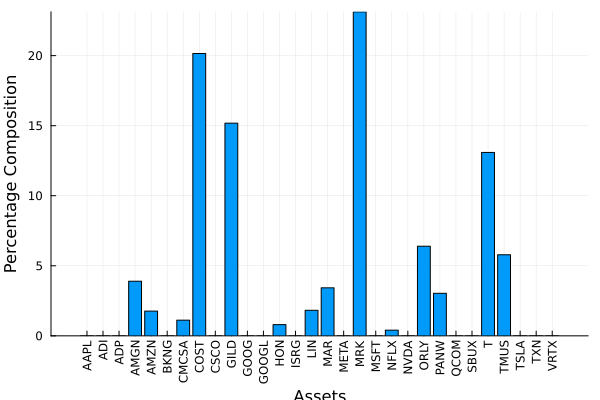

In [3]:
plot_bar(port)

### 2.3. Efficient frontier

In [4]:
points = 50
frontier = efficient_frontier!(port, type; points = points)
pretty_table(frontier[:weights]; formatters = fmt2)

┌─────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬──────────┬─────────┬─────────┬──────────┐
│ tickers │        1 │        2 │        3 │        4 │        5 │        6 │        7 │        8 │        9 │       10 │       11 │       12 │       13 │       14 │       15 │       16 │       17 │       18 │       19 │       20 │       21 │       22 │       23 │       24 │       25 │       26 │       27 │       28 │       29 │       30 │       31 │       32 │       33 │       34 │       35 │       36 │       37 │       38 │

Plot frontier.

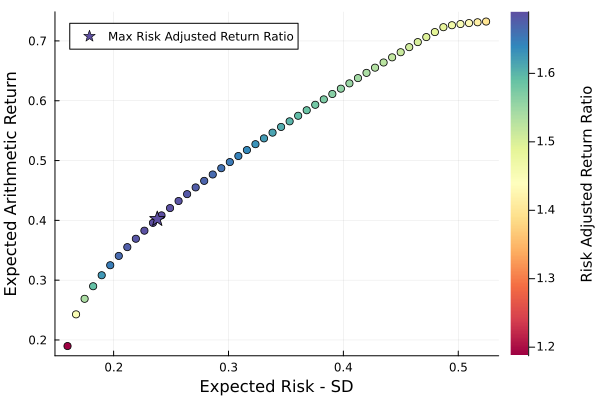

In [5]:
plot_frontier(port; rm = rm)

Plot frontier area.

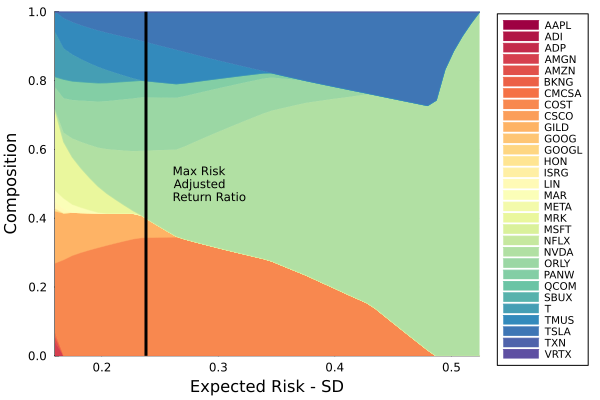

In [6]:
plot_frontier_area(port; rm = rm, kwargs_a = (; legendfontsize = 7))

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*